### Required data

This notebooks assumes the presence of genomes in the `genomes` folder and the presence of annotations (external and JGI's) in the `annotation/external` and `annotation/jgi` folders. The rest of the data is generated from these files.

TODO: Download the above-mentioned files from figshare or similar.

### Common data prep

Extract idenditifers

In [1]:
ls genomes | cut -f1 -d. > list

Prepare proteins

In [5]:
%%bash
mkdir -p peptides/{jgi,external}
cat list | xargs -P 16 -I {} bash -c 'gffread -y peptides/jgi/{}.primaryTrs.fa . -g genomes/{}.genome.fasta annotation/jgi/{}.primaryTrs.gff3'
cat list | xargs -P 16 -I {} bash -c 'gffread -y peptides/external/{}.primaryTrs.fa . -g genomes/{}.genome.fasta annotation/external/{}.primaryTrs.gff3'

#### GENESPACE runs

1. Genespace data preparation

In [14]:
%%bash
mkdir -p genespace/{external,jgi}

cd genespace/jgi
mkdir -p gs/{peptide,bed}
cat ../../list | xargs -I {} bash -c 'tr < ../../peptides/jgi/{}.primaryTrs.fa ":" "_" > gs/peptide/{}.fa'
cat ../../list | xargs -I {} bash -c 'gffread ../../annotation/jgi/{}.primaryTrs.gff3 -T |  grep CDS | gffread | grep transcript | cut -f1,4,5,9 | sed "s/ID=//" | cut -f1 -d ";" | sed "s/:/_/g" > gs/bed/{}.bed'
mv gs/peptide/58-161.fa gs/peptide/58_161.fa; mv gs/bed/58-161.bed gs/bed/58_161.bed 

cd ../external
mkdir -p gs/{peptide,bed}
cat ../../list | xargs -I {} bash -c 'tr < ../../peptides/external/{}.primaryTrs.fa ":" "_" > gs/peptide/{}.fa'
cat ../../list | xargs -I {} bash -c 'gffread ../../annotation/external/{}.primaryTrs.gff3 -T |  grep CDS | gffread | grep transcript | cut -f1,4,5,9 | sed "s/ID=//" | cut -f1 -d ";" | sed "s/:/_/g" > gs/bed/{}.bed'
mv gs/peptide/58-161.fa gs/peptide/58_161.fa; mv gs/bed/58-161.bed gs/bed/58_161.bed 


2. GENESPACE is run through its [Docker container](https://hub.docker.com/layers/doejgi/genespace/latest/images/sha256-064a3cc98a063e001219ced78ab75ea3ed7fa2f678dcc64aade987c37ae231e6). The following commands use Apptainer to execute the GENESPACE script.

In [ ]:
%%bash
cd genespace/jgi
apptainer exec -B ${PWD}:${PWD} docker://doejgi/genespace@sha256:064a3cc98a063e001219ced78ab75ea3ed7fa2f678dcc64aade987c37ae231e6 Rscript ../../../scripts/run_genespace.R 
cd ../external
apptainer exec -B ${PWD}:${PWD} docker://doejgi/genespace@sha256:064a3cc98a063e001219ced78ab75ea3ed7fa2f678dcc64aade987c37ae231e6 Rscript ../../../scripts/run_genespace.R 

### Annotation statistics

Generation of BUSCO and PSAURON statistics for the main overview table. BUSCO is run through the Docker container with Apptainer, PSAURON needs to be installed locally (see instructions here https://github.com/salzberg-lab/PSAURON).

In [ ]:
%%bash
generateStats() {
    group=$1
    cd $group
    for id in $(cat ../../list); do
      mkdir $id; cd $id
      ln -s ../../../peptides/${group}/${id}.primaryTrs.fa proteins.fa
      apptainer exec -B ${PWD}:${PWD} docker://ezlabgva/busco:v5.8.2_cv1 busco -m protein -l fabales_odb10 -i proteins.fa -o fabalesBusco
      psauron -i proteins.fa -o psauron.csv -c -p -v &> psauron.log
      cd ..
    done
    cd ..
}

mkdir -p stats/{jgi,external}
cd stats

generateStats jgi
generateStats external

### Pangenome expansion

In [ ]:
%%bash
mkdir pangenomeExpansion
../scripts/computePanExpansionDiamond.py peptides/jgi pangenomeExpansion/jgi_70.tsv --identity 70 --coverage 70 --threads 16
../scripts/computePanExpansionDiamond.py peptides/external pangenomeExpansion/external_70.tsv --identity 70 --coverage 70 --threads 16

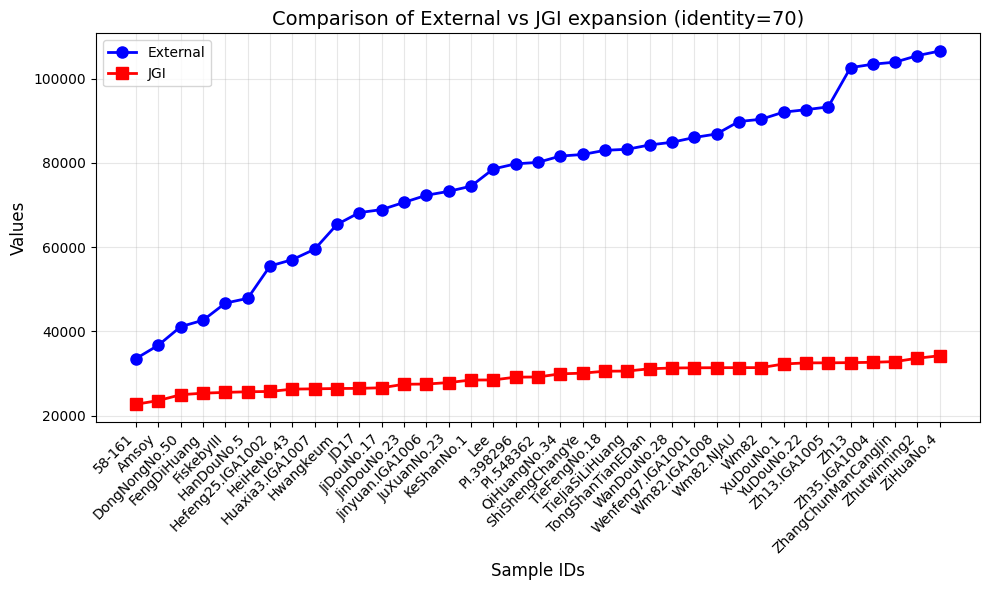

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def parse_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    identity = lines[0].strip().split('=')[1]
    
    ids = []
    values = []
    
    for line in lines[1:-1]:
        parts = line.strip().split()
        if len(parts) >= 2:
            ids.append(parts[0].replace('.primaryTrs', ''))
            values.append(int(parts[1]))
    
    return identity, ids, values

identity1, ids1, values1 = parse_file('pangenomeExpansion/external_70.tsv')
identity2, ids2, values2 = parse_file('pangenomeExpansion/jgi_70.tsv')

fig, ax = plt.subplots(figsize=(10, 6))

x_positions = np.arange(len(ids1))
ax.plot(x_positions, values1, 'b-o', label='External', markersize=8, linewidth=2)
ax.plot(x_positions, values2, 'r-s', label='JGI', markersize=8, linewidth=2)

ax.set_xticks(x_positions)
ax.set_xticklabels(ids1, rotation=45, ha='right')

ax.set_xlabel('Sample IDs', fontsize=12)
ax.set_ylabel('Values', fontsize=12)
ax.set_title(f'Comparison of External vs JGI expansion (identity={identity1})', fontsize=14)

ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

### PAV estimate with get_homologues-est

Prepare the transcripts

In [20]:
%%bash
mkdir -p pav_estimate/{jgi/ests,external/ests}
cat list | xargs -I {} bash -c 'gffread -x pav_estimate/jgi/ests/{}.primaryTrs.fa . -g genomes/{}.genome.fasta annotation/jgi/{}.primaryTrs.gff3'
cat list | xargs -I {} bash -c 'gffread -x pav_estimate/external/ests/{}.primaryTrs.fa . -g genomes/{}.genome.fasta annotation/external/{}.primaryTrs.gff3'

To obtain `get_homologoues-est` results, execute the following commands in both folders (`pav_estimate/jgi` and `pav_estimate/external`). The expected runtime is several hours.

```bash
apptainer exec -B ${PWD}:${PWD} docker://csicunam/get_homologues:20230108 get_homologues-est.pl -d ests -n 64 -M -t 0
apptainer exec -B ${PWD}:${PWD} docker://csicunam/get_homologues:20230108 compare_clusters.pl -d ests_est_homologues/*_0taxa_algOMCL_e0_/ -o clusters_out -n -m
apptainer exec -B ${PWD}:${PWD} docker://csicunam/get_homologues:20230108 parse_pangenome_matrix.pl -m clusters_out/pangenome_matrix_t0.tab -s
```

The PAV visualization script is a modified version of https://github.com/eead-csic-compbio/get_homologues/blob/97653341c027c2c4491a85369c7aa8af8045e146/parse_pangenome_matrix.pl

In [ ]:
%%bash
y=40000
../scripts/parse_pangenome_matrix.pl -m pav_estimate/external/clusters_out/pangenome_matrix_t0.tab  -s -y $y
../scripts/parse_pangenome_matrix.pl -m pav_estimate/jgi/clusters_out/pangenome_matrix_t0.tab  -s -y $y

#### Restulting PAV estimate figures (external and JGI)

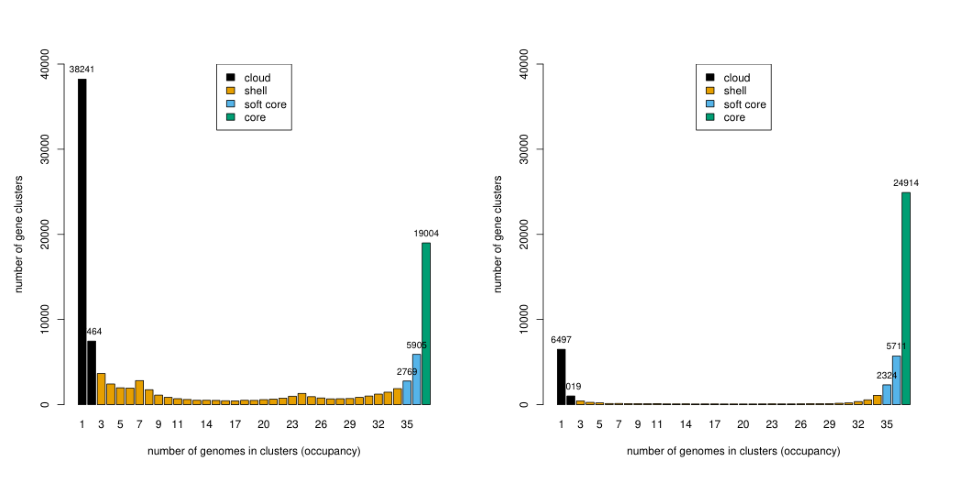

In [32]:
import fitz
from IPython.display import display, Image
import matplotlib.pyplot as plt
import io

plt.figure(figsize=(15, 6))
plt.subplot(121); plt.imshow(plt.imread(io.BytesIO(fitz.open("pav_estimate/external/clusters_out/pangenome_matrix_t0__shell.pdf")[0].get_pixmap().tobytes("png")))); plt.axis('off')
plt.subplot(122); plt.imshow(plt.imread(io.BytesIO(fitz.open("pav_estimate/jgi/clusters_out/pangenome_matrix_t0__shell.pdf")[0].get_pixmap().tobytes("png")))); plt.axis('off')
plt.subplots_adjust(wspace=-0.3)


### Annotation Consistency Evaluation

#### Data preparation

1. We want to compare only the protein coding predictions. Prepare a gff3s with just coding regions:

In [1]:
%%bash
cd annotation/jgi; mkdir coding_regions; ls *.gff3  |  xargs -I {} bash -c 'gffread -T {} | grep -P "\tCDS\t"| gffread --keep-genes | sed "s/\ttranscript\t/\tmRNA\t/" > coding_regions/{}'; cd ../..
cd annotation/external; mkdir coding_regions; ls *.gff3  |  xargs -I {} bash -c 'gffread -T {} | grep -P "\tCDS\t"| gffread --keep-genes | sed "s/\ttranscript\t/\tmRNA\t/" > coding_regions/{}'l


2. Run a WDL workflow that lifts genes between all pairs of annotations/genomes with Liftoff.
* Prepare inputs for the worklow:

In [35]:
%%bash
mkdir -p consistency/{jgi,external}/liftoff
cd consistency/jgi/liftoff
cat ../../../list  | xargs -I {} bash -c 'echo -en "../../../genomes/{}.genome.fasta\t../../../annotation/jgi/coding_regions/{}.primaryTrs.gff3\n"' > pairs.tsv
../../../../scripts/WDL/tsvToJsonInput.py pairs.tsv > input.json
cd ../../external/liftoff
cat ../../../list  | xargs -I {} bash -c 'echo -en "../../../genomes/{}.genome.fasta\t../../../annotation/external/coding_regions/{}.primaryTrs.gff3\n"' > pairs.tsv
../../../../scripts/WDL/tsvToJsonInput.py pairs.tsv > input.json

- b. Run the WDL workflow `/scripts/WDL/liftAll.wdl` with the `input.json` for both external and jgi annotations and copy all pairwise comparsions (the `$ID.genome.fasta_to_$ID.genome.fasta.gff3` files) to a `results` folder in `consistency/{jgi,external}/liftoff/results`

#### Annotation Consistency Visualition

In [ ]:
%%bash
cd consistency/jgi;
../../../scripts/visualize_pairwise_consistency.py ../../annotation/jgi/coding_regions/ liftoff/results gffCompare  --mappingThreshold 1  --save-csv  --noCellTex --order ../order.txt --palette magma_r
../../../scripts/visualize_pairwise_consistency.py ../../annotation/jgi/coding_regions/ liftoff/results gffCompare  --mappingThreshold 1  --save-csv  --noCellTex --order ../order.txt --palette plasma_r
cd ../external
../../../scripts/visualize_pairwise_consistency.py ../../annotation/external/coding_regions/ liftoff/results gffCompare  --mappingThreshold 1  --save-csv  --noCellTex --order ../order.txt --palette magma_r
../../../scripts/visualize_pairwise_consistency.py ../../annotation/external/coding_regions/ liftoff/results gffCompare  --mappingThreshold 1  --save-csv  --noCellTex --order ../order.txt --palette plasma_r

#### Consistency of perfect matches

(np.float64(-0.5), np.float64(702.5), np.float64(603.5), np.float64(-0.5))

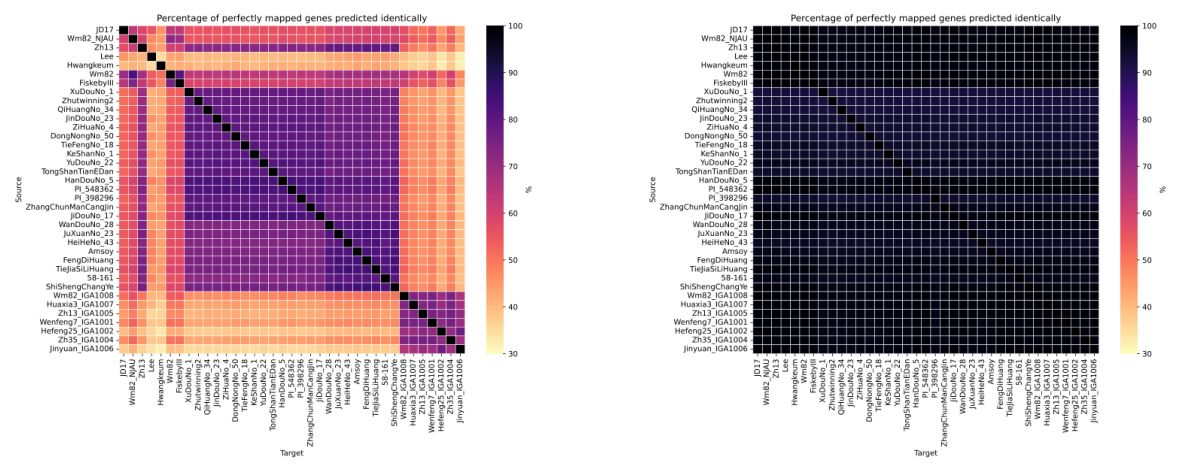

In [20]:
import fitz
from IPython.display import display, Image
import matplotlib.pyplot as plt
import io

plt.figure(figsize=(15, 6))
plt.subplot(121); plt.imshow(plt.imread(io.BytesIO(fitz.open("consistency/external/gene_identity_1.0_magma_r.pdf")[0].get_pixmap().tobytes("png")))); plt.axis('off')
plt.subplot(122); plt.imshow(plt.imread(io.BytesIO(fitz.open("consistency/jgi/gene_identity_1.0_magma_r.pdf")[0].get_pixmap().tobytes("png")))); plt.axis('off')

(np.float64(-0.5), np.float64(702.5), np.float64(603.5), np.float64(-0.5))

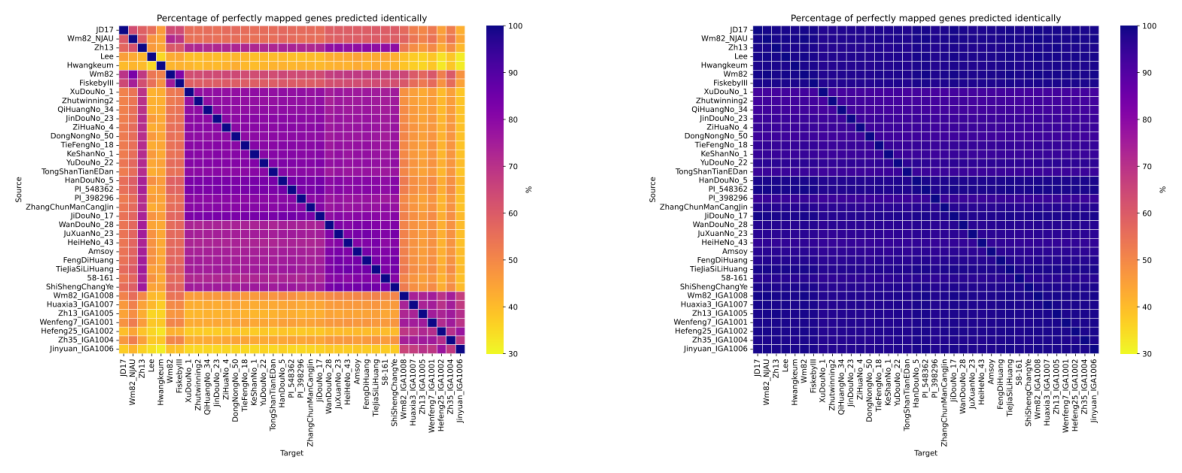

In [21]:
plt.figure(figsize=(15, 6))
plt.subplot(121); plt.imshow(plt.imread(io.BytesIO(fitz.open("consistency/external/gene_identity_1.0_plasma_r.pdf")[0].get_pixmap().tobytes("png")))); plt.axis('off')
plt.subplot(122); plt.imshow(plt.imread(io.BytesIO(fitz.open("consistency/jgi/gene_identity_1.0_plasma_r.pdf")[0].get_pixmap().tobytes("png")))); plt.axis('off')

#### Consistency of approximate matches

(np.float64(-0.5), np.float64(702.5), np.float64(603.5), np.float64(-0.5))

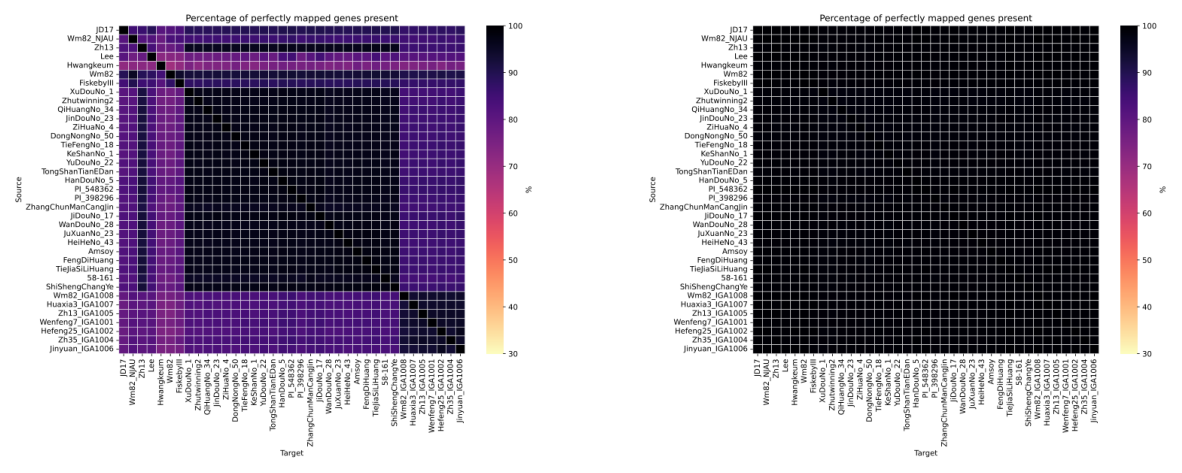

In [22]:
plt.figure(figsize=(15, 6))
plt.subplot(121); plt.imshow(plt.imread(io.BytesIO(fitz.open("consistency/external/gene_presence_1.0_magma_r.pdf")[0].get_pixmap().tobytes("png")))); plt.axis('off')
plt.subplot(122); plt.imshow(plt.imread(io.BytesIO(fitz.open("consistency/jgi/gene_presence_1.0_magma_r.pdf")[0].get_pixmap().tobytes("png")))); plt.axis('off')

(np.float64(-0.5), np.float64(702.5), np.float64(603.5), np.float64(-0.5))

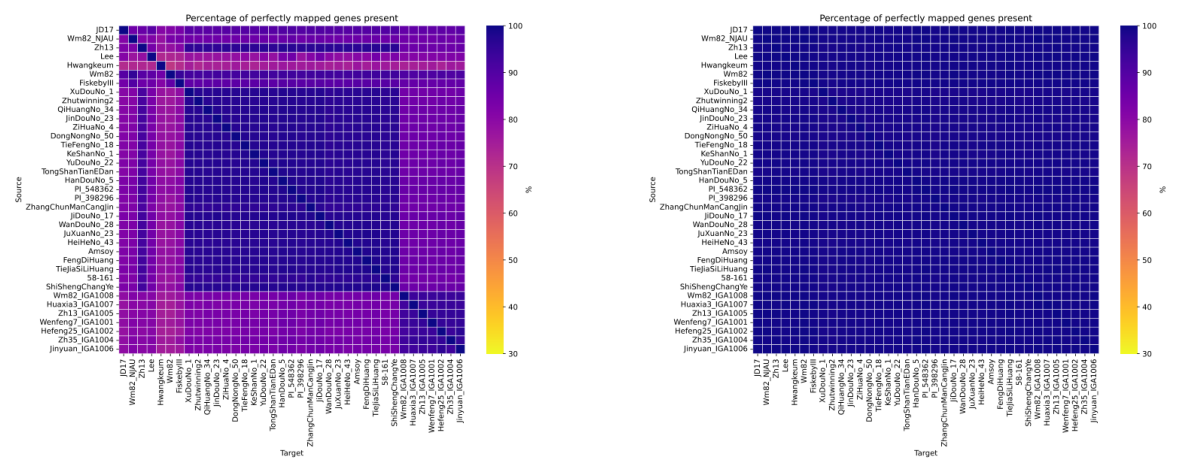

In [23]:
plt.figure(figsize=(15, 6))
plt.subplot(121); plt.imshow(plt.imread(io.BytesIO(fitz.open("consistency/external/gene_presence_1.0_plasma_r.pdf")[0].get_pixmap().tobytes("png")))); plt.axis('off')
plt.subplot(122); plt.imshow(plt.imread(io.BytesIO(fitz.open("consistency/jgi/gene_presence_1.0_plasma_r.pdf")[0].get_pixmap().tobytes("png")))); plt.axis('off')

### Analysis of IGC with native RNA-Seq

Protein translation and statistics

In [ ]:
%%bash
mkdir peptides/jgi_native_rna
gffread -y peptides/jgi_native_rna/YuDouNo_22.primaryTrs.fa . -g genomes/YuDouNo_22.genome.fasta annotation/jgi_native_rna/YuDouNo_22.primaryTrs.gff3

mkdir -p stats/jgi_native_rna/YuDouNo_22
cd stats/jgi_native_rna/YuDouNo_22
ln -s ../../../peptides/jgi_native_rna/YuDouNo_22.primaryTrs.fa proteins.fa
apptainer exec -B ${PWD}:${PWD} docker://ezlabgva/busco:v5.8.2_cv1 busco -m protein -l fabales_odb10 -i proteins.fa -o fabalesBusco
psauron -i proteins.fa -o psauron.csv -c -p -v &> psauron.log

mkdir: cannot create directory ‘peptides/jgi_native_rna’: File exists


In [ ]:
%%bash
mkdir native_rna_expansion/{jgi_regular,jgi_native,external};
echo -e "jgi_regular\njgi_native\nexternal" | xargs -I {} bash -c 'cp peptides/jgi/Wm82.primaryTrs.fa native_rna_expansion/{}'
cp peptides/jgi/YuDouNo_22.primaryTrs.fa native_rna_expansion/jgi_regular
cp peptides/external/YuDouNo_22.primaryTrs.fa native_rna_expansion/external
cp peptides/jgi_native_rna//YuDouNo_22.primaryTrs.fa native_rna_expansion/jgi_native

echo -e "jgi_regular\njgi_native\nexternal" | xargs -I {} bash -c '../scripts/computePanExpansionDiamond.py native_rna_expansion/{}/ native_rna_expansion/{}.tsv --identity 70 --coverage 70 --threads 16'

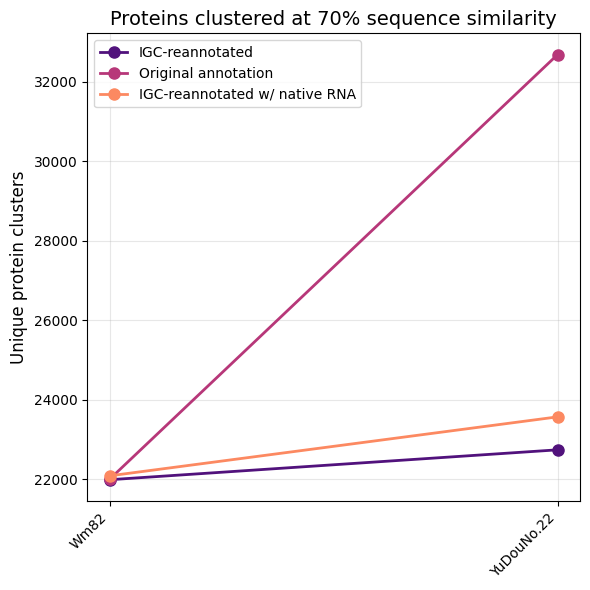

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def parse_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    identity = lines[0].strip().split('=')[1]
    
    ids = []
    values = []
    
    for line in lines[1:-1]:
        parts = line.strip().split()
        if len(parts) >= 2:
            ids.append(parts[0].replace('.primaryTrs', ''))
            values.append(int(parts[1]))
    
    return identity, ids, values

identity1, ids1, values1 = parse_file('native_rna_expansion/external.tsv')
identity2, ids2, values2 = parse_file('native_rna_expansion/jgi_regular.tsv')
identity3, ids3, values3 = parse_file('native_rna_expansion/jgi_native.tsv')

# Ensure all ids are the same
if not (ids1 == ids2 == ids3):
    raise ValueError("Sample IDs must be the same across all files")

fig, ax = plt.subplots(figsize=(6, 6))

x_positions = np.arange(len(ids1))

# Use seaborn's magma color palette
colors = sns.color_palette("magma", 3)

ax.plot(x_positions, values2, 'o-', color=colors[0], label='IGC-reannotated', markersize=8, linewidth=2)
ax.plot(x_positions, values1, 'o-', color=colors[1], label='Original annotation', markersize=8, linewidth=2)
ax.plot(x_positions, values3, 'o-', color=colors[2], label='IGC-reannotated w/ native RNA', markersize=8, linewidth=2)

ax.set_xticks(x_positions)
ax.set_xticklabels(ids1, rotation=45, ha='right')

ax.set_ylabel('Unique protein clusters', fontsize=12)
ax.set_title(f'Proteins clustered at 70% sequence similarity', fontsize=14)

ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig('native_rna_expansion/protein_clusters.pdf')
plt.show()